In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.3 MB/s eta 0:00:00


In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

stock_data = yf.download('^BSESN')


num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy


# Here I choose to only use the last 3 years of stock data
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# Here I Choose to continue with only Close value column since that is what we care about
stock_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)
    df['lag2'] = df[target].shift(num_days_pred*2)
    df['lag3'] = df[target].shift(num_days_pred*3)
    df['lag4'] = df[target].shift(num_days_pred*4)
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)

    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

[*********************100%%**********************]  1 of 1 completed


# XGBoost

In [3]:
pip install xgboost

In [4]:
from xgboost import XGBRegressor
df_xgb = stock_data.copy()
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)

    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb)
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

[I 2024-04-15 10:07:39,561] A new study created in memory with name: no-name-6dfcd515-995f-4263-afee-adca3b20d0cb
[I 2024-04-15 10:07:41,200] Trial 0 finished with value: 840.088596640098 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.053908538579065676, 'subsample': 0.9952367423732238, 'colsample_bytree': 0.950902656923489, 'reg_alpha': 5.776850971366924, 'reg_lambda': 0.6888288467454651}. Best is trial 0 with value: 840.088596640098.
[I 2024-04-15 10:07:46,650] Trial 1 finished with value: 810.8183591296422 and parameters: {'n_estimators': 362, 'max_depth': 10, 'learning_rate': 0.09634637373987048, 'subsample': 0.7549522487974678, 'colsample_bytree': 0.7124787788701686, 'reg_alpha': 0.02084010640045153, 'reg_lambda': 6.855726478365842}. Best is trial 1 with value: 810.8183591296422.
[I 2024-04-15 10:07:47,568] Trial 2 finished with value: 766.6452550384931 and parameters: {'n_estimators': 195, 'max_depth': 7, 'learning_rate': 0.08765735939069179, 'subsample

Best trial:
  Value: 758.318982284036
  Params: 
    n_estimators: 463
    max_depth: 4
    learning_rate: 0.054476819075798794
    subsample: 0.631526446344608
    colsample_bytree: 0.6562377110318487
    reg_alpha: 3.2794353003152903
    reg_lambda: 3.682807618477483
Test RMSE: 758.318982284036
ERROR PERCENT = 1.1798379850122538% 


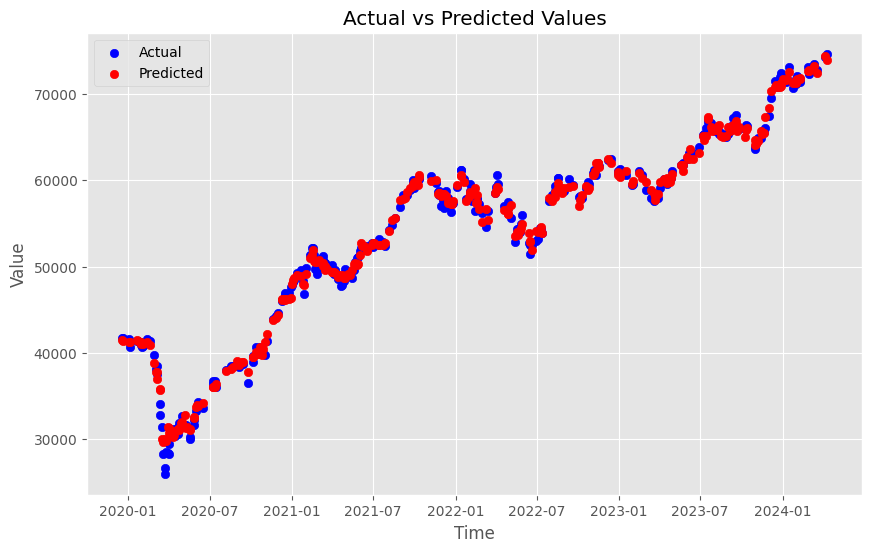

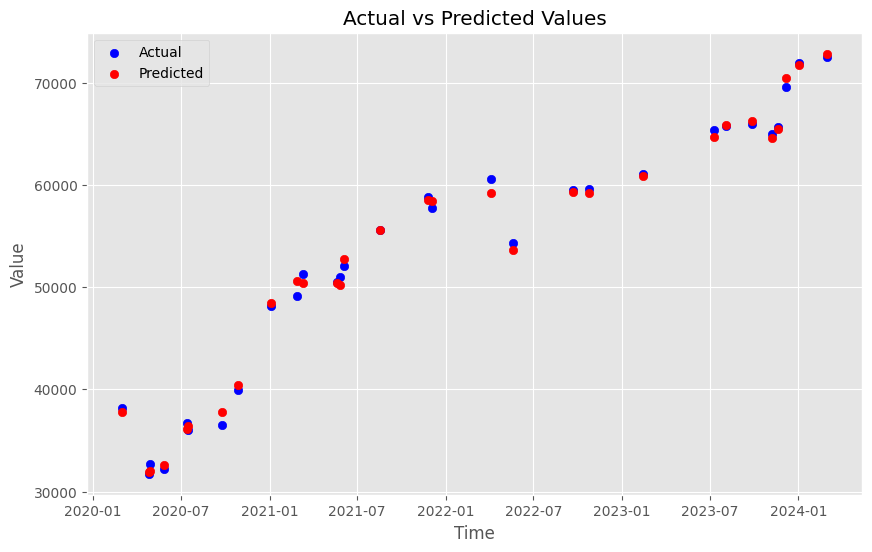

<Figure size 1000x600 with 0 Axes>

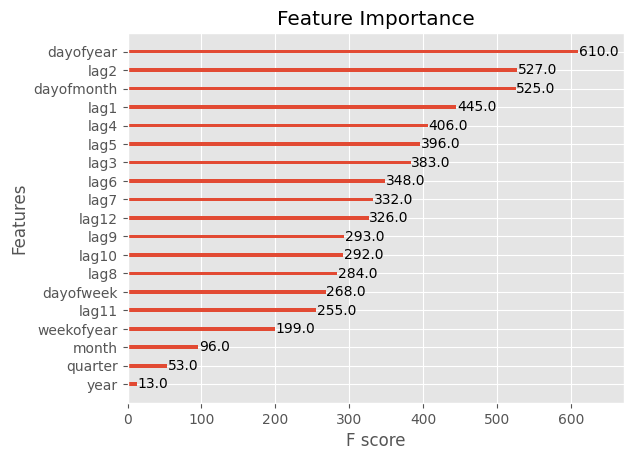

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()


In [7]:
start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

future_w_features['pred'] = xgb_best.predict(future_w_features.drop(columns=['Close','isFuture']))
prediction_xgb = pd.DataFrame(future_w_features['pred'])
prediction_xgb

,pred
2024-04-15,73773.921875
2024-04-16,73466.382812
2024-04-17,73462.609375
2024-04-18,73067.921875
2024-04-19,72782.398438
2024-04-20,72660.578125
2024-04-21,72573.203125
2024-04-22,72439.843750
2024-04-23,72320.710938
2024-04-24,72482.812500


# LightGBM

In [8]:
pip install lightgbm

In [9]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna

df_lgb = stock_data.copy()

def lightgbm_model(df_lgb, add_lags, create_features, num_days_pred=num_days_pred):
    df_lgb = create_features(df_lgb)
    df_lgb = add_lags(df_lgb)

    X = df_lgb.drop(columns='Close')
    y = df_lgb['Close']
    return X, y

X, y = lightgbm_model(df_lgb, add_lags, create_features, num_days_pred=30)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': -1,
    }

    # Initialize LightGBM regressor with the suggested parameters
    lgb_reg = lgb.LGBMRegressor(**param)

    # Fit the model on training data
    lgb_reg.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = lgb_reg.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
lgb_best = lgb.LGBMRegressor(**best_params)
lgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = lgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

# Calculate mean absolute percentage error on the test set
lgb_loss = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"ERROR PERCENT = {lgb_loss}% ")


[I 2024-04-15 10:09:18,628] A new study created in memory with name: no-name-9c87ba7c-eafc-41f2-84b9-de45fced178d
[I 2024-04-15 10:09:18,899] Trial 0 finished with value: 813.6294071012427 and parameters: {'num_leaves': 76, 'max_depth': 6, 'learning_rate': 0.08260821324989405, 'subsample': 0.6888739108331505, 'colsample_bytree': 0.6691800693296829, 'reg_alpha': 3.029736203338249, 'reg_lambda': 4.537506488816193}. Best is trial 0 with value: 813.6294071012427.
[I 2024-04-15 10:09:19,091] Trial 1 finished with value: 1022.2181745290815 and parameters: {'num_leaves': 83, 'max_depth': 10, 'learning_rate': 0.046708800110123794, 'subsample': 0.9381156968634071, 'colsample_bytree': 0.7500227418032902, 'reg_alpha': 4.602448246215865, 'reg_lambda': 6.205521777099001}. Best is trial 0 with value: 813.6294071012427.
[I 2024-04-15 10:09:19,272] Trial 2 finished with value: 860.8986676209804 and parameters: {'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.06519933873647474, 'subsample': 0.8895

Best trial:
  Value: 785.3005133884469
  Params: 
    num_leaves: 60
    max_depth: 8
    learning_rate: 0.09581377079929285
    subsample: 0.7229993337919037
    colsample_bytree: 0.6010301979985726
    reg_alpha: 8.765396712060047
    reg_lambda: 2.8101985818669215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 747, number of used features: 19
[LightGBM] [Info] Start training from score 54642.695388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

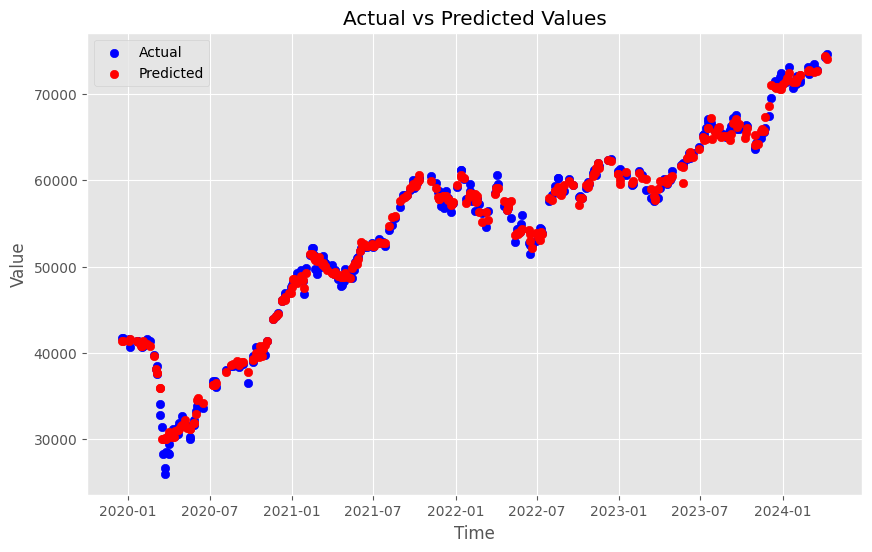

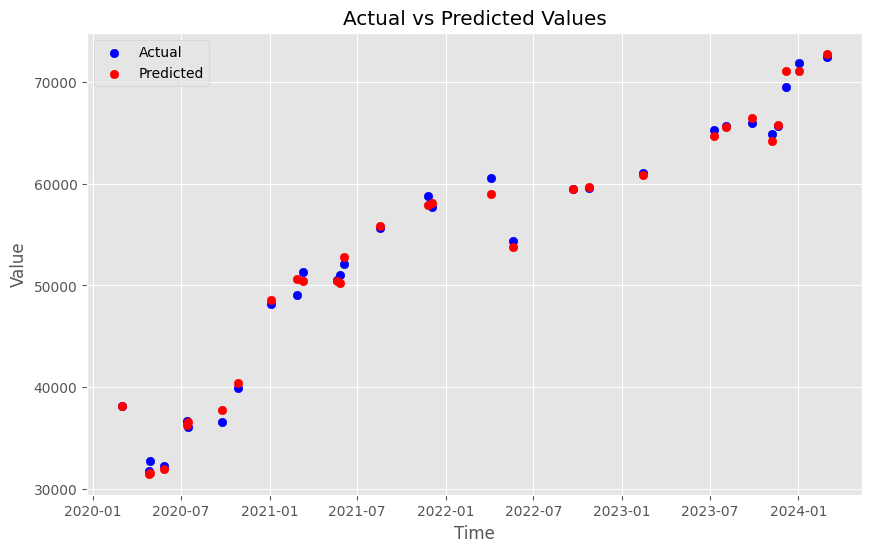

<Figure size 1000x600 with 0 Axes>

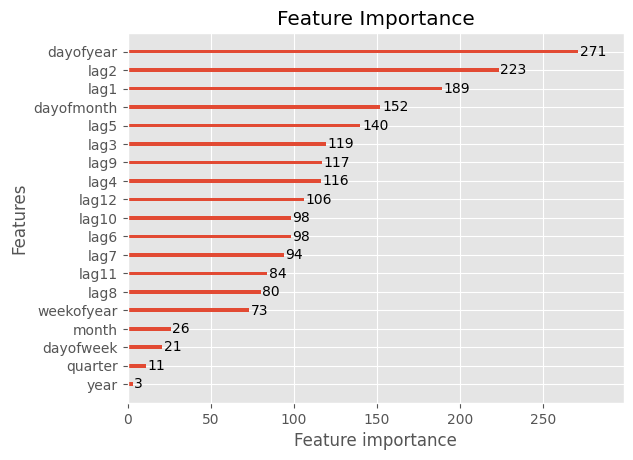

In [11]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test, color='red', label='Predicted')  # Using y_pred_test from LightGBM
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Zooming in
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test[:30], color='red', label='Predicted')  # Using y_pred_test from LightGBM
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot feature importance for LightGBM
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()


In [12]:
# Generating predictions for future using LightGBM
start = df_lgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

future = pd.date_range(start=start, end=end, freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_lgb['isFuture'] = False
df_and_future = pd.concat([df_lgb, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

future_w_features['pred'] = lgb_best.predict(future_w_features.drop(columns=['Close', 'isFuture']))
prediction_lgb = pd.DataFrame(future_w_features['pred'])

# CatBoost

In [13]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 10.0 MB/s eta 0:00:00


In [14]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

# Define functions
def catboostmodel(df, add_lags, create_features, num_days_pred=num_days_pred):
    df = create_features(df)
    df = add_lags(df)

    X = df.drop(columns='Close')
    y = df['Close']
    return X, y

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'od_type': 'Iter',
        'od_wait': 25,
        'verbose': False
    }

    # Initialize CatBoost regressor with the suggested parameters
    catboost = CatBoostRegressor(**param)

    # Create pool object for training
    train_pool = Pool(X_train, label=y_train)

    # Fit the model on training data
    catboost.fit(train_pool)

    # Predict on the validation set
    y_pred = catboost.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse



In [15]:
# Split data and perform feature engineering
df_catboost = stock_data.copy()
X, y = catboostmodel(df_catboost, add_lags, create_features, num_days_pred=30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
catboost_best = CatBoostRegressor(**best_params)
catboost_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = catboost_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-15 10:09:45,066] A new study created in memory with name: no-name-4cb4e960-3c13-4d9f-a32d-b394910563d3
[I 2024-04-15 10:09:52,691] Trial 0 finished with value: 1243.4492202570714 and parameters: {'iterations': 236, 'learning_rate': 0.03532279007372359, 'depth': 9, 'l2_leaf_reg': 6.106538297976565, 'random_strength': 5.4669185608986295, 'bagging_temperature': 8.129607720868165}. Best is trial 0 with value: 1243.4492202570714.
[I 2024-04-15 10:10:11,062] Trial 1 finished with value: 871.2506275827158 and parameters: {'iterations': 212, 'learning_rate': 0.07353867679185855, 'depth': 10, 'l2_leaf_reg': 1.1309567957631994, 'random_strength': 4.795719240220767, 'bagging_temperature': 6.1670580734716225}. Best is trial 1 with value: 871.2506275827158.
[I 2024-04-15 10:10:45,472] Trial 2 finished with value: 857.6659471983908 and parameters: {'iterations': 675, 'learning_rate': 0.07965753085654541, 'depth': 10, 'l2_leaf_reg': 0.8525336691188423, 'random_strength': 3.4741048125225356

Best trial:
  Value: 757.5318963819254
  Params: 
    iterations: 632
    learning_rate: 0.05885021321801766
    depth: 7
    l2_leaf_reg: 1.7862460106875102
    random_strength: 1.5370898972058251
    bagging_temperature: 3.5017813206867774
0:	learn: 10412.4009573	total: 6.37ms	remaining: 4.02s
1:	learn: 9904.1652081	total: 13.1ms	remaining: 4.12s
2:	learn: 9396.4263698	total: 19.6ms	remaining: 4.11s
3:	learn: 8962.0465097	total: 26.3ms	remaining: 4.13s
4:	learn: 8495.8322888	total: 35.9ms	remaining: 4.5s
5:	learn: 8080.9696067	total: 42ms	remaining: 4.38s
6:	learn: 7728.0254070	total: 48ms	remaining: 4.29s
7:	learn: 7340.9960534	total: 54.2ms	remaining: 4.23s
8:	learn: 6988.0534660	total: 60.5ms	remaining: 4.19s
9:	learn: 6636.7183792	total: 66.8ms	remaining: 4.16s
10:	learn: 6330.8315543	total: 73.4ms	remaining: 4.14s
11:	learn: 6029.6714686	total: 79.8ms	remaining: 4.12s
12:	learn: 5740.8172156	total: 86.2ms	remaining: 4.11s
13:	learn: 5480.4798946	total: 92.8ms	remaining: 4.09s
14

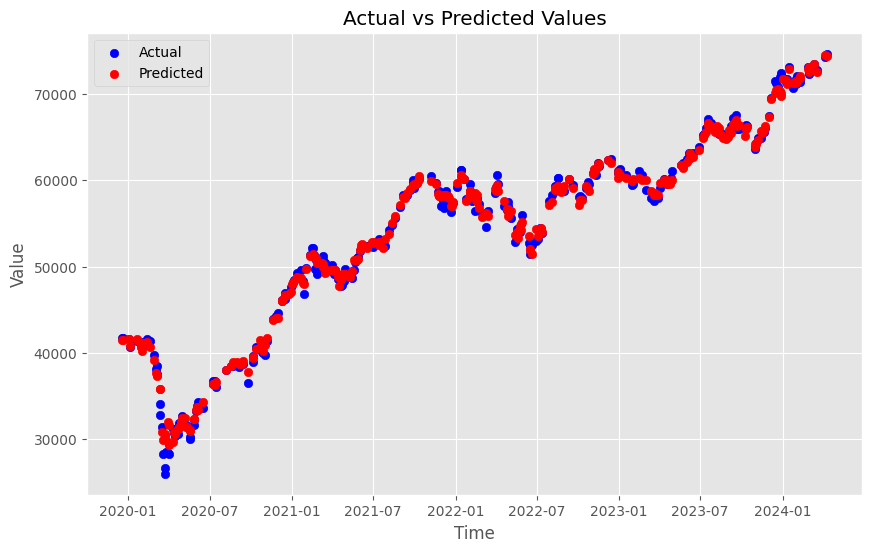

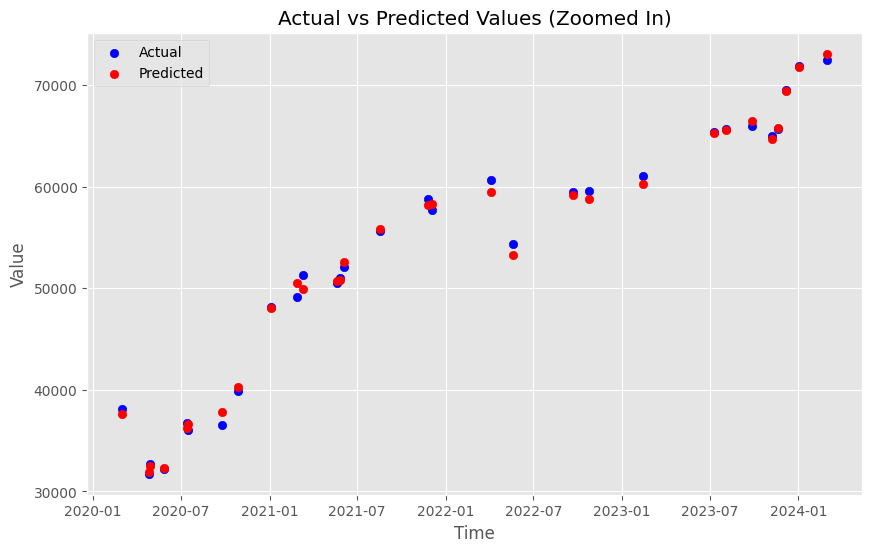

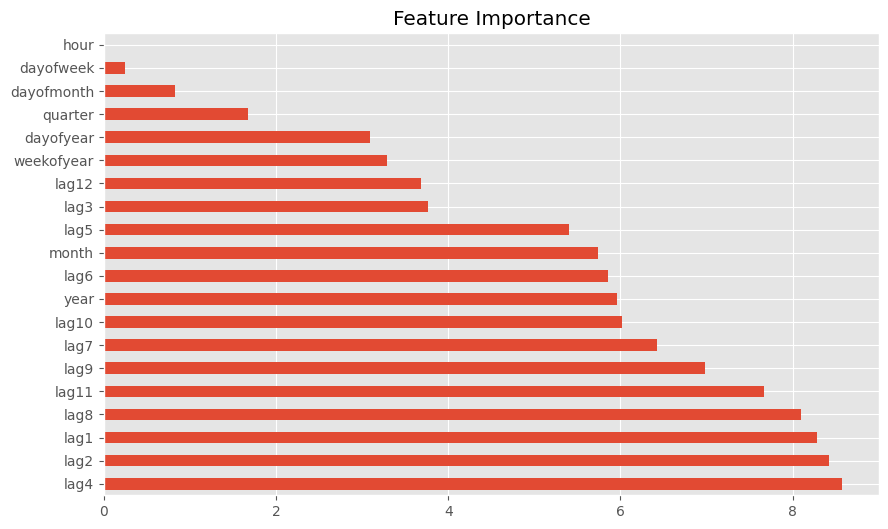

In [16]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test, color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Actual vs Predicted Values (Zoomed In)
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test[:30], color='red', label='Predicted')
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(catboost_best.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importance")
plt.show()


In [17]:
# Predict future values
start = df_catboost.index.max()
end = start + pd.Timedelta(days=num_days_pred)
future = pd.date_range(start=start, end=end, freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_catboost['isFuture'] = False
df_and_future = pd.concat([df_catboost, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = catboost_best.predict(future_w_features.drop(columns=['Close', 'isFuture']))
prediction_catboost = pd.DataFrame(future_w_features['pred'])
prediction_catboost

,pred
2024-04-15,73555.859961
2024-04-16,73618.568153
2024-04-17,73407.495152
2024-04-18,73140.026528
2024-04-19,72357.956373
2024-04-20,72146.563153
2024-04-21,72015.817228
2024-04-22,72148.518806
2024-04-23,72211.844026
2024-04-24,72151.076486


# HistGradientBoostingRegressor

In [18]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
import matplotlib.pyplot as plt

# Define functions
def gbm_model(df, add_lags, create_features, num_days_pred=num_days_pred):
    df = create_features(df)
    df = add_lags(df)

    X = df.drop(columns='Close')
    y = df['Close']
    return X, y

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'max_iter': trial.suggest_int('max_iter', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    # Initialize HistGradientBoostingRegressor with the suggested parameters
    gbm = HistGradientBoostingRegressor(**param)

    # Fit the model on training data
    gbm.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = gbm.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


In [19]:
# Split data and perform feature engineering
df_gbm = stock_data.copy()
X, y = gbm_model(df_gbm, add_lags, create_features, num_days_pred=30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params

# Initialize HistGradientBoostingRegressor with the best parameters
gbm_best = HistGradientBoostingRegressor(**best_params)

# Fit the model on training data
gbm_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = gbm_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-15 10:12:12,080] A new study created in memory with name: no-name-69104dfc-a31d-4e27-afc4-c9187f3e208c
[I 2024-04-15 10:12:13,404] Trial 0 finished with value: 1149.393743580941 and parameters: {'max_iter': 189, 'learning_rate': 0.01652252153768452, 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 1149.393743580941.
[I 2024-04-15 10:12:14,887] Trial 1 finished with value: 878.3821452219023 and parameters: {'max_iter': 500, 'learning_rate': 0.27337927596862394, 'max_depth': 7, 'min_samples_leaf': 10}. Best is trial 1 with value: 878.3821452219023.
[I 2024-04-15 10:12:15,801] Trial 2 finished with value: 995.6268987590107 and parameters: {'max_iter': 602, 'learning_rate': 0.5134948578792906, 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 878.3821452219023.
[I 2024-04-15 10:12:17,738] Trial 3 finished with value: 904.8670532257978 and parameters: {'max_iter': 624, 'learning_rate': 0.4394405859241147, 'max_depth': 7, 'min_samples_leaf': 8}

Best trial:
  Value: 816.5291645967166
  Params: 
    max_iter: 847
    learning_rate: 0.11010918009369952
    max_depth: 5
    min_samples_leaf: 3
Test RMSE: 816.5291645967166


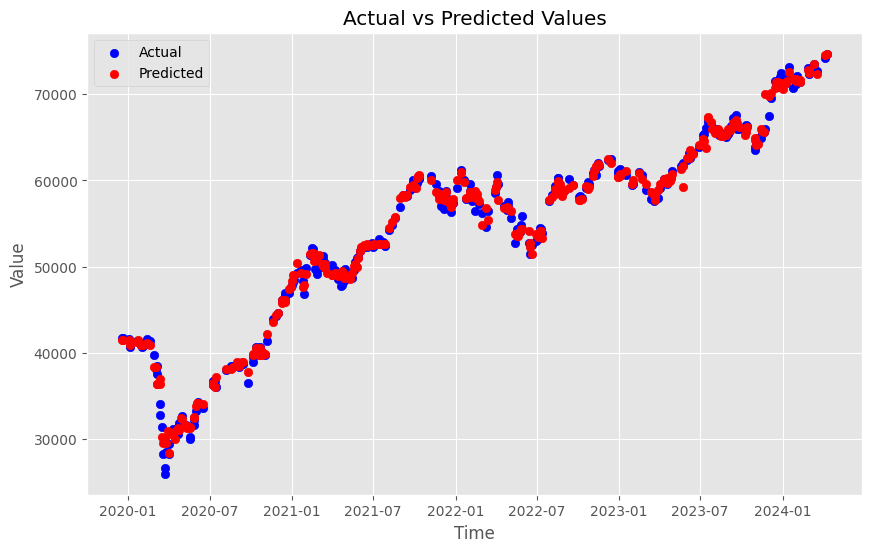

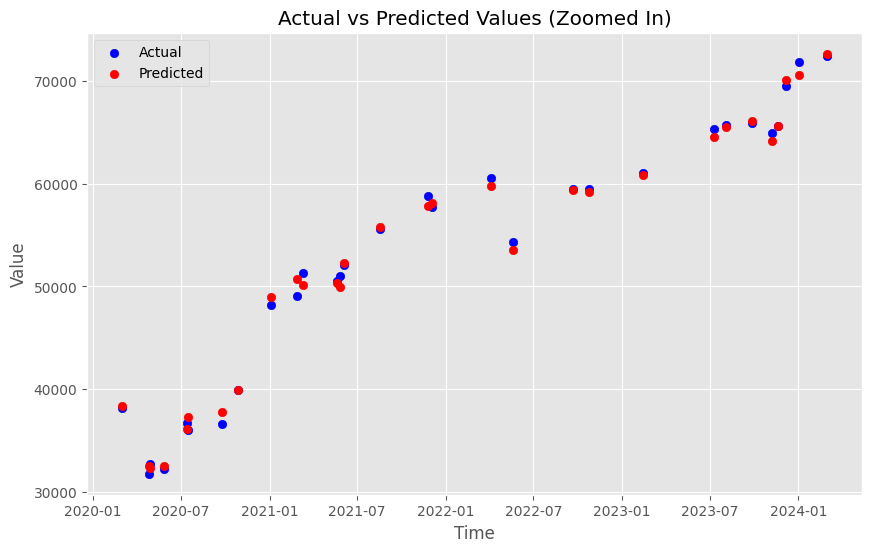

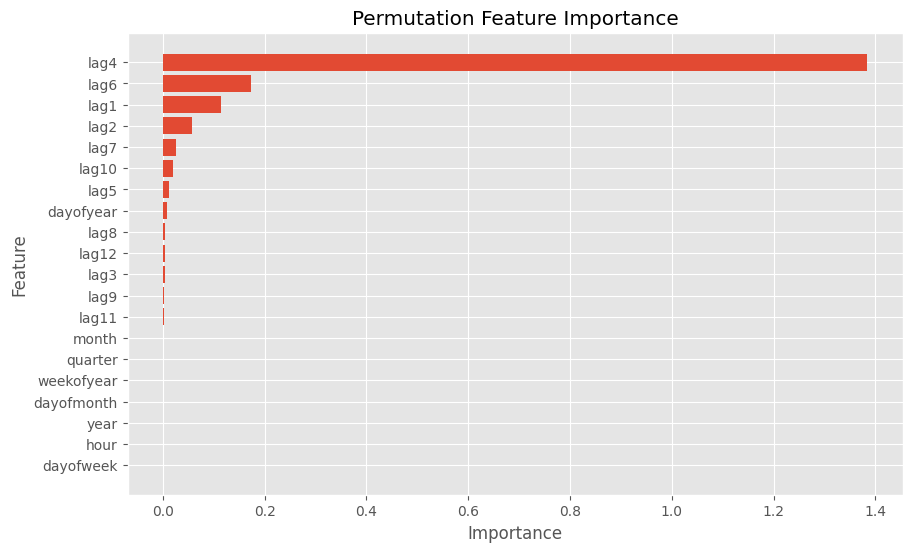

In [20]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test, color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Actual vs Predicted Values (Zoomed In)
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test[:30], color='red', label='Predicted')
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate permutation importance
result = permutation_importance(gbm_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get sorted feature indices by importance
sorted_idx = result.importances_mean.argsort()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [21]:
# Predict future values
start = df_gbm.index.max()
end = start + pd.Timedelta(days=num_days_pred)
future = pd.date_range(start=start, end=end, freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_gbm['isFuture'] = False
df_and_future = pd.concat([df_gbm, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = gbm_best.predict(future_w_features.drop(columns=['Close', 'isFuture']))
prediction_gbm = pd.DataFrame(future_w_features['pred'])
prediction_gbm

,pred
2024-04-15,73484.024575
2024-04-16,73260.516156
2024-04-17,73339.083326
2024-04-18,73521.459665
2024-04-19,73054.493781
2024-04-20,73158.941004
2024-04-21,73039.886172
2024-04-22,72940.792882
2024-04-23,72928.365442
2024-04-24,72815.251307


# Results

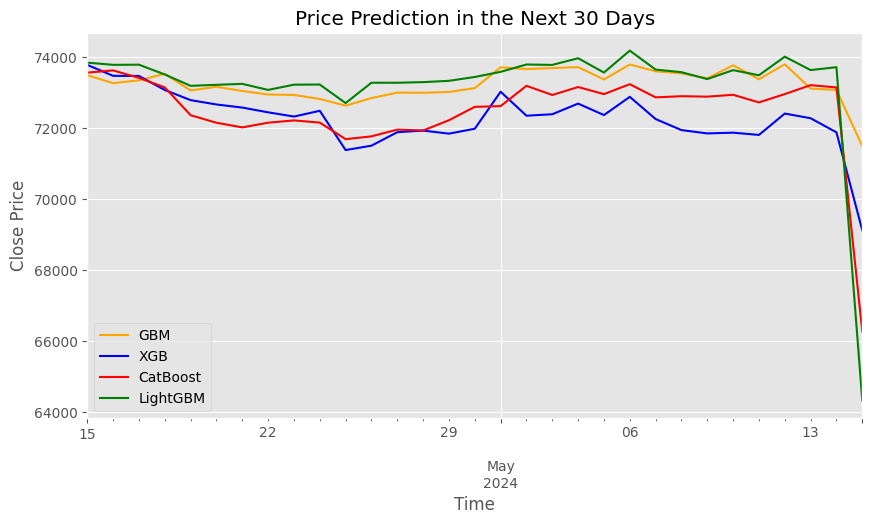

In [22]:
fig, ax  = plt.subplots(figsize=(10,5))
prediction_gbm.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
prediction_catboost.plot(color = 'red',ax=ax)
prediction_lgb.plot(color = 'green',ax=ax)
plt.legend(['GBM','XGB','CatBoost', 'LightGBM'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");
